# Coronavirus - Global Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os, re, pickle

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.rcParams['figure.figsize']=[32, 18]
plt.rcParams['font.size']=16
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 16

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Crucial Oubtreak Data

## Load Data

Load the most recent data available on the Covid-19 epidemic from the `CSSEGISandData` repository. 

There are three reports that are interesting to us: *confirmed cases*, *fatalities* and *recovered cases*.
All the cases for a specific region (from different provinces/states) are summed under the umbrella of that region to have country-level granularity on our data.

In [25]:
# uncomment below to load latest data

# coronavirus_confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')\
#                         .drop(["Lat", "Long", "Province/State"], axis=1)\
#                         .groupby('Country/Region').sum()\
#                         .transpose()
# coronavirus_confirmed_df.to_csv("../data/raw/coronavirus_confirmed_global.csv")
coronavirus_confirmed_df = pd.read_csv("../data/raw/coronavirus_confirmed_global.csv", index_col=0)

# coronavirus_death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')\
#                     .drop(["Lat", "Long", "Province/State"], axis=1)\
#                     .groupby('Country/Region').sum()\
#                     .transpose()
# coronavirus_death_df.to_csv("../data/raw/coronavirus_death_global.csv")
coronavirus_death_df = pd.read_csv("../data/raw/coronavirus_death_global.csv", index_col=0)

# coronavirus_recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')\
#                     .drop(["Lat", "Long", "Province/State"], axis=1)\
#                     .groupby('Country/Region').sum()\
#                     .transpose()
# coronavirus_recovered_df.to_csv("../data/raw/coronavirus_recovered_global.csv")
coronavirus_recovered_df = pd.read_csv("../data/raw/coronavirus_recovered_global.csv", index_col=0)

## Clean Data

### Remove Reclassifications

Within the data, there are inconsistencies related the cumulative number of cases dropping from one day to the next due to re-classifications in the data. To address this, we correct the data by taking the cumulative minimum of cases in reverse order, as to ensure monoticity of all of our cumulative curves.

In [26]:
def verify_monotonicity(df):
    return df.apply(lambda s: s.is_monotonic).all()

def consider_reclassifications(df):
    return df[::-1].cummin()[::-1]

#### Confirmed Cases

In [27]:
verify_monotonicity(coronavirus_confirmed_df)

False

In [28]:
coronavirus_confirmed_df = consider_reclassifications(coronavirus_confirmed_df)
verify_monotonicity(coronavirus_confirmed_df)

True

#### Fatalities

In [29]:
verify_monotonicity(coronavirus_death_df)

False

In [30]:
coronavirus_death_df = consider_reclassifications(coronavirus_death_df)
verify_monotonicity(coronavirus_death_df)

True

#### Recovered Cases

In [31]:
verify_monotonicity(coronavirus_recovered_df)

False

In [32]:
coronavirus_recovered_df = consider_reclassifications(coronavirus_recovered_df)
verify_monotonicity(coronavirus_recovered_df)

True

## Save Data

Now that we've appropriately treated and cleaned our data, we can store for further analysis in CSV files. We will store the daily date as opposed to cumulative as our analysis will need the data in that format.

In [34]:
coronavirus_confirmed_df.diff(axis=0).fillna(0).to_csv("../data/clean/coronavirus_confirmed_global.csv")
coronavirus_death_df.diff(axis=0).fillna(0).to_csv("../data/clean/coronavirus_death_global.csv")
coronavirus_recovered_df.diff(axis=0).fillna(0).to_csv("../data/clean/coronavirus_recovered_global.csv")

# Secondary Data

## Testing Policy

This dataset, found in *Our World in Data*, represents the evolution of testing strategies for countries from early April, until mid-May. The data provides a way to understand how the (later parts) of the crucial statistics were collected (whether at a hospital, or at a broader level) and, therefore, how representative the data above are likely to be. Note that we only have testing policy data available for 135 countries (as opposed to the 185 countries listed above). The lack of monotonicity and large gaps in reporting are disconcerting and indicate we should consider the data with a grain of salt. Instead of considering the entirety of the data for further analysis, we will construct a simple boolean indicator (called `advanced_testing_policy_adopted`) of a country's policy during the entire outbreak which indicates whether they have engaged in either symptomatic or open testing at any point (values 2 or 3).

The different policy descriptions are:

    0: No testing policy

    1: Only those who both (a) have symptoms AND (b) meet specific criteria (eg key workers, admitted to hospital, came into contact with a known case, returned from overseas)

    2: testing of anyone showing COVID-19 symptoms

    3: open public testing (eg “drive through” testing available to asymptomatic people)
    


In [13]:
coronavirus_testing_policies = pd.read_csv("../data/raw/covid-19-testing-policy.csv")\
                                 .pivot(index="Date", columns="Entity", values="Testing policy (OxBSG)")\
                                 .rename({
                                    'Czech Republic': "Czechia", 
                                    'United States': "US", 
                                    'Myanmar': "Burma", 
                                    'South Korea': "Korea, South", 
                                    'Taiwan': "Taiwan*"
                                }, axis=1)

In [14]:
coronavirus_testing_policies

Entity,Afghanistan,Albania,Algeria,Andorra,Angola,Argentina,Aruba,Australia,Austria,Azerbaijan,...,United Arab Emirates,United Kingdom,US,Uruguay,Uzbekistan,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
"Apr 1, 2020",1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,1.0,1.0,3.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0
"Apr 10, 2020",1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,1.0,1.0,3.0,1.0,1.0,1.0,3.0,0.0,1.0,0.0
"Apr 11, 2020",1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,1.0,1.0,3.0,1.0,1.0,1.0,3.0,0.0,1.0,0.0
"Apr 12, 2020",1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,1.0,1.0,3.0,1.0,1.0,1.0,3.0,0.0,1.0,0.0
"Apr 13, 2020",1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,3.0,1.0,3.0,1.0,1.0,1.0,3.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"May 5, 2020",NaN,2.0,0.0,3.0,2.0,1.0,NaN,1.0,2.0,NaN,...,NaN,1.0,3.0,1.0,1.0,1.0,3.0,0.0,NaN,NaN
"May 6, 2020",NaN,2.0,0.0,3.0,2.0,1.0,NaN,1.0,2.0,NaN,...,NaN,1.0,3.0,1.0,1.0,1.0,3.0,0.0,NaN,NaN
"May 7, 2020",NaN,2.0,0.0,3.0,NaN,1.0,NaN,NaN,2.0,NaN,...,NaN,1.0,3.0,1.0,1.0,1.0,3.0,0.0,NaN,NaN


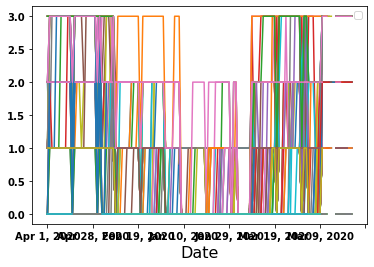

In [15]:
coronavirus_testing_policies.plot()
plt.legend([])
plt.show()

In [16]:
advanced_testing_policy_adopted = coronavirus_testing_policies.apply(lambda s: (s >= 2).any())

In [17]:
advanced_testing_policy_adopted.value_counts()

True     87
False    73
dtype: int64

In [18]:
advanced_testing_policy_adopted[advanced_testing_policy_adopted].index

Index(['Albania', 'Andorra', 'Angola', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belgium', 'Benin', 'Bosnia and Herzegovina',
       'Brunei', 'Cameroon', 'Canada', 'Cape Verde', 'Chile', 'China',
       'Colombia', 'Costa Rica', 'Cote d'Ivoire', 'Croatia', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Estonia', 'Gabon', 'Ghana', 'Greece', 'Greenland', 'Guam',
       'Guatemala', 'Honduras', 'Hong Kong', 'Iceland', 'India', 'Iraq',
       'Ireland', 'Italy', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait',
       'Luxembourg', 'Macao', 'Madagascar', 'Malaysia', 'Morocco', 'Burma',
       'New Zealand', 'Oman', 'Pakistan', 'Panama', 'Papua New Guinea',
       'Paraguay', 'Peru', 'Philippines', 'Portugal', 'Romania', 'Russia',
       'Rwanda', 'San Marino', 'Saudi Arabia', 'Seychelles', 'Sierra Leone',
       'Singapore', 'Slovenia', 'South Africa', 'Korea, South', 'South Sudan',
       'Spain', 'Sri 

In [19]:
advanced_testing_policy_adopted.to_csv("../data/clean/coronavirus_advanced_testing_policy_adopted.csv")

## Testing per 1,000 people

In [20]:
coronavirus_testing_df = pd.read_csv("../data/raw/full-list-cumulative-total-tests-per-thousand.csv")\
                                           .pivot(index="Date", columns="Entity", values="Total tests per thousand")\
                                           .rename({
                                                'Czech Republic': "Czechia", 
                                                'United States': "US", 
                                                'Myanmar': "Burma", 
                                                'South Korea': "Korea, South", 
                                                'Taiwan': "Taiwan*"
                                            }, axis=1).drop([
                                                'United States, specimens tested (CDC)',
                                                'Japan, tests performed', 
                                                'India, people tested', 
                                                'Italy, tests performed', 
                                                'United Kingdom, tests performed', 
                                                'Singapore, swabs tested'
                                            ], axis=1)

In [21]:
latest_testing_per_thousand = coronavirus_testing_df.fillna(method='ffill').iloc[-1]

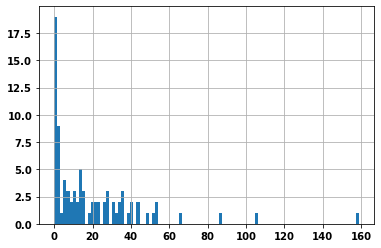

In [22]:
latest_testing_per_thousand.hist(bins=100)

In [23]:
latest_testing_per_thousand.sort_values().head(20)

Entity
Vietnam        0.027
Nigeria        0.116
Burma          0.206
Ethiopia       0.264
Brazil         0.296
Indonesia      0.397
Nepal          0.560
Kenya          0.577
Zimbabwe       0.645
Bangladesh     0.710
Bolivia        0.730
Mexico         0.884
Morocco        1.003
India          1.104
Senegal        1.207
Pakistan       1.222
Philippines    1.248
Uganda         1.263
Thailand       1.390
Japan          1.676
Name: May 9, 2020, dtype: float64

In [24]:
latest_testing_per_thousand.to_csv("../data/clean/coronavirus_latest_testing_per_thousand.csv")